Link to Medium post:[Let's talk about Signals](https://parmarsuraj99.medium.com/lets-talk-about-signals-841934f24450)

## Libraries and imports

In [1]:
!pip install kaggle

In [2]:
!pip install numerapi
!pip install yfinance
!pip install simplejson

!pip install catboost

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=9af0e8699a3c3622e65de77f9892b2207920360d1b0bb05dd6c4bae6591e9dbb
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 129 kB 5.2 MB/s 
     |████████████████████████████████| 76.4 MB 53 kB/s 


In [3]:
import gc, os

import numerapi
import yfinance
import simplejson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

Tickers that Numerai signals want. These are bloomberg tickers. yfinance asks for yahoo finance tickers.

## Data acquisition

In [4]:
napi = numerapi.SignalsAPI()

eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")
print(f"Number of eligible tickers : {len(eligible_tickers)}")

print(eligible_tickers.head(10))

Number of eligible tickers : 5340
0    SVW AU
1    GEM AU
2    AZJ AU
3    NXT AU
4    TWE AU
5    SGR AU
6    CKF AU
7    BGA AU
8    QUB AU
9    MMS AU
Name: bloomberg_ticker, dtype: object


This file has mapping from bloomberg to yahoo finance tickers.
So, we can use yfinance tickers to download and then map/rename them back to bloomberg tickers.

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/signals"
# import sys
# sys.path.append('/content/drive/My Drive/signals')

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [7]:
ticker_map = pd.read_csv(
        'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv'
        #'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/universe/latest.csv'
)
print(len(ticker_map))

ticker_map.head()

#Yahoo <-> Bloomberg mapping
yfinance_tickers = eligible_tickers.map(
        dict(zip(ticker_map["bloomberg_ticker"], ticker_map["yahoo"]))
        #dict(zip(ticker_map["bloomberg_ticker"], ticker_map["stooq"]))
    ).dropna()

bloomberg_tickers = ticker_map["bloomberg_ticker"]

print(f"Number of eligible, mapped tickers: {len(yfinance_tickers)}")


5340
Number of eligible, mapped tickers: 5290


These are tickers that Numerai signals wants and are also in the mapping dictionary

In [8]:
!kaggle datasets download -d code1110/yfinance-stock-price-data-for-numerai-signals

 97% 384M/394M [00:02<00:00, 170MB/s]
100% 394M/394M [00:02<00:00, 164MB/s]


In [9]:
# full_df = pd.read_csv("full_data.csv")

In [17]:
full_df = pd.read_csv(r"../content/yfinance-stock-price-data-for-numerai-signals.zip")

In [18]:
full_df = pd.merge(ticker_map, full_df, on='ticker')
full_df.set_index('date', inplace=True)

In [19]:
full_df

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume
date,,,,,,,,,
2002-12-02,000060 KS,000060 KS,000060.KS,614.203308,1327.944214,1327.944214,1327.944214,1327.944214,0.0
2002-12-03,000060 KS,000060 KS,000060.KS,626.406128,1354.329956,1354.329956,1301.561157,1310.359985,1319031.0
2002-12-04,000060 KS,000060 KS,000060.KS,587.764160,1270.781006,1349.930054,1257.589966,1349.930054,1564644.0
2002-12-05,000060 KS,000060 KS,000060.KS,583.696594,1261.989990,1288.369995,1253.192383,1275.180054,2324224.0
2002-12-06,000060 KS,000060 KS,000060.KS,585.730347,1266.383789,1270.781006,1231.209961,1253.192383,1848918.0
...,...,...,...,...,...,...,...,...,...
2021-10-04,ZZZ.,ZZZ CN,ZZZ.TO,33.299999,33.299999,33.974998,32.779999,33.770000,63800.0
2021-10-05,ZZZ.,ZZZ CN,ZZZ.TO,33.610001,33.610001,33.790001,33.139999,33.340000,27600.0
2021-10-06,ZZZ.,ZZZ CN,ZZZ.TO,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0


In [20]:
#A day's data
full_df.groupby("date").get_group("2005-12-01")

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume
date,,,,,,,,,
2005-12-01,000060 KS,000060 KS,000060.KS,2566.816162,3860.711914,4120.144531,3790.360107,3790.360107,314941.0
2005-12-01,000100 KS,000100 KS,000100.KS,21930.300781,21930.300781,22222.701172,21637.900391,21813.335938,210163.0
2005-12-01,000120 KS,000120 KS,000120.KS,146178.234375,146178.234375,147939.421875,144593.171875,146178.234375,8079.0
2005-12-01,000210 KS,000210 KS,000210.KS,61165.808594,67300.000000,67600.000000,65900.000000,67000.000000,146600.0
2005-12-01,000270 KS,000270 KS,000270.KS,18925.216797,23750.000000,24200.000000,23000.000000,24000.000000,7893870.0
...,...,...,...,...,...,...,...,...,...
2005-12-01,ZIXI,ZIXI US,ZIXI,1.650000,1.650000,1.800000,1.620000,1.780000,1018400.0
2005-12-01,ZOT SM,ZOT SM,ZOT.MC,8.372209,16.349800,16.572800,16.193617,16.572800,146860.0
2005-12-01,ZUMZ,ZUMZ US,ZUMZ,20.334999,20.334999,20.725000,20.000000,20.475000,327800.0


In [21]:
print(f"Number of tickers with data: {len(full_df.ticker.unique())}")

Number of tickers with data: 5290


## Technical Indicators

In [22]:
def RSI(prices, interval=14):
    '''Computes Relative Strength Index given a price series and lookback interval
    Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    See more here https://www.investopedia.com/terms/r/rsi.asp'''
    delta = prices.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(interval).mean()
    RolDown = dDown.rolling(interval).mean().abs()

    RS = RolUp / RolDown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def sma(prices, window=10):

    return (sum(prices, window))/window

In [23]:
ticker_groups = full_df.groupby('ticker')
full_df["RSI"] = ticker_groups["close"].transform(lambda x: RSI(x))
full_df["SMA_10"] = ticker_groups["close"].transform(lambda x: sma(x, 10))

2021-10-10 09:25:45,252 INFO numexpr.utils: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-10 09:25:45,253 INFO numexpr.utils: NumExpr defaulting to 8 threads.


In [24]:
#a list of tickers used in full_df.columns to ease the calculation.
indicators = ['RSI', 'SMA_10']

In [25]:
full_df

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10
date,,,,,,,,,,,
2002-12-02,000060 KS,000060 KS,000060.KS,614.203308,1327.944214,1327.944214,1327.944214,1327.944214,0.0,NaN,4.471169e+06
2002-12-03,000060 KS,000060 KS,000060.KS,626.406128,1354.329956,1354.329956,1301.561157,1310.359985,1319031.0,NaN,4.471169e+06
2002-12-04,000060 KS,000060 KS,000060.KS,587.764160,1270.781006,1349.930054,1257.589966,1349.930054,1564644.0,NaN,4.471169e+06
2002-12-05,000060 KS,000060 KS,000060.KS,583.696594,1261.989990,1288.369995,1253.192383,1275.180054,2324224.0,NaN,4.471169e+06
2002-12-06,000060 KS,000060 KS,000060.KS,585.730347,1266.383789,1270.781006,1231.209961,1253.192383,1848918.0,NaN,4.471169e+06
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04,ZZZ.,ZZZ CN,ZZZ.TO,33.299999,33.299999,33.974998,32.779999,33.770000,63800.0,45.766582,3.712517e+03
2021-10-05,ZZZ.,ZZZ CN,ZZZ.TO,33.610001,33.610001,33.790001,33.139999,33.340000,27600.0,44.883716,3.712517e+03
2021-10-06,ZZZ.,ZZZ CN,ZZZ.TO,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0,38.326004,3.712517e+03


2021-10-10 09:28:17,145 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-10-10 09:28:17,153 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-10-10 09:28:18,096 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-10-10 09:28:18,103 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


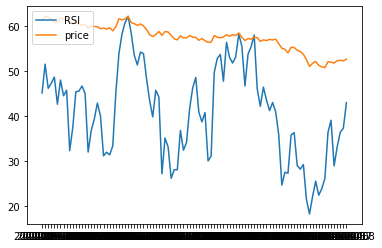

In [26]:
plt.plot(full_df[full_df['ticker']=="1 HK"]["RSI"][-100:], label='RSI')
plt.plot(full_df[full_df['ticker']=="1 HK"]["close"][-100:], label='price')
plt.legend(loc='upper left')

plt.show()

In [27]:
%%time

date_groups = full_df.groupby(full_df.index)

for indicator in indicators:
    print(indicator)
    full_df[f"{indicator}_quintile"] = date_groups[indicator].transform(
        lambda group: pd.qcut(group, 5, labels=False, duplicates='drop')
    ).astype(np.float32)
    gc.collect()

RSI
SMA_10
CPU times: user 2min 34s, sys: 1.88 s, total: 2min 36s
Wall time: 2min 35s


In [28]:
full_df.head()

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile
date,,,,,,,,,,,,,
2002-12-02,000060 KS,000060 KS,000060.KS,614.203308,1327.944214,1327.944214,1327.944214,1327.944214,0.0,NaN,4.471169e+06,NaN,4.0
2002-12-03,000060 KS,000060 KS,000060.KS,626.406128,1354.329956,1354.329956,1301.561157,1310.359985,1319031.0,NaN,4.471169e+06,NaN,4.0
2002-12-04,000060 KS,000060 KS,000060.KS,587.764160,1270.781006,1349.930054,1257.589966,1349.930054,1564644.0,NaN,4.471169e+06,NaN,4.0
2002-12-05,000060 KS,000060 KS,000060.KS,583.696594,1261.989990,1288.369995,1253.192383,1275.180054,2324224.0,NaN,4.471169e+06,NaN,4.0
2002-12-06,000060 KS,000060 KS,000060.KS,585.730347,1266.383789,1270.781006,1231.209961,1253.192383,1848918.0,NaN,4.471169e+06,NaN,4.0


Let's encode historical RSI into features

In [29]:
ticker_groups = full_df.groupby("ticker")

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc

for indicator in indicators:
    num_days = 5
    for day in range(num_days + 1):
        full_df[f"{indicator}_quintile_lag_{day}"] = ticker_groups[
            f"{indicator}_quintile"
        ].transform(lambda group: group.shift(day))

    gc.collect()


In [30]:
full_df.tail()

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-04,ZZZ.,ZZZ CN,ZZZ.TO,33.299999,33.299999,33.974998,32.779999,33.770000,63800.0,45.766582,3712.516606,2.0,1.0,2.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-05,ZZZ.,ZZZ CN,ZZZ.TO,33.610001,33.610001,33.790001,33.139999,33.340000,27600.0,44.883716,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-06,ZZZ.,ZZZ CN,ZZZ.TO,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0,38.326004,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-07,ZZZ.,ZZZ CN,ZZZ.TO,33.500000,33.500000,33.709999,32.860001,32.860001,57200.0,41.848396,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-08,ZZZ.,ZZZ CN,ZZZ.TO,33.389999,33.389999,34.070000,33.290001,33.290001,72400.0,41.255145,3712.516606,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [31]:
# create difference of the lagged features (change in RSI quintile by day)
for indicator in indicators:
    for day in range(num_days):
        full_df[f"{indicator}_diff_{day}"] = (
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )
        full_df[f"{indicator}_abs_diff_{day}"] = np.abs(
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )

    gc.collect()


In [32]:
full_df.tail()

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-04,ZZZ.,ZZZ CN,ZZZ.TO,33.299999,33.299999,33.974998,32.779999,33.770000,63800.0,45.766582,3712.516606,2.0,1.0,2.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-05,ZZZ.,ZZZ CN,ZZZ.TO,33.610001,33.610001,33.790001,33.139999,33.340000,27600.0,44.883716,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-06,ZZZ.,ZZZ CN,ZZZ.TO,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0,38.326004,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-07,ZZZ.,ZZZ CN,ZZZ.TO,33.500000,33.500000,33.709999,32.860001,32.860001,57200.0,41.848396,3712.516606,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,ZZZ.,ZZZ CN,ZZZ.TO,33.389999,33.389999,34.070000,33.290001,33.290001,72400.0,41.255145,3712.516606,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
full_df[full_df["ticker"]=="ZEL NZ"]

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-08-19,ZEL NZ,ZEL NZ,ZEL.NZ,2.502345,3.66,3.74,3.64,3.73,52973302.0,NaN,920.850777,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-20,ZEL NZ,ZEL NZ,ZEL.NZ,2.557041,3.74,3.77,3.68,3.69,12375671.0,NaN,920.850777,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-21,ZEL NZ,ZEL NZ,ZEL.NZ,2.591227,3.79,3.79,3.73,3.75,13797490.0,NaN,920.850777,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-22,ZEL NZ,ZEL NZ,ZEL.NZ,2.584389,3.78,3.79,3.76,3.78,7792682.0,NaN,920.850777,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2013-08-23,ZEL NZ,ZEL NZ,ZEL.NZ,2.577552,3.77,3.80,3.76,3.78,5760601.0,NaN,920.850777,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04,ZEL NZ,ZEL NZ,ZEL.NZ,3.410000,3.41,3.44,3.40,3.41,818721.0,37.037037,920.850777,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-05,ZEL NZ,ZEL NZ,ZEL.NZ,3.410000,3.41,3.41,3.38,3.40,1054408.0,41.666667,920.850777,2.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-06,ZEL NZ,ZEL NZ,ZEL.NZ,3.400000,3.40,3.41,3.39,3.41,1051387.0,37.500000,920.850777,2.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
feature_names = [f for f in full_df.columns for y in ['lag', 'diff'] if y in f]

## Historical Numerai Targets

In [35]:
TARGET_NAME = "target_20d"
PREDICTION_NAME = "signal"

In [36]:
url = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv"
targets = pd.read_csv(url)
targets.head()

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d
0,000270 KS,20030131,train,0.50,0.50
1,000810 KS,20030131,train,0.50,0.50
2,000830 KS,20030131,train,0.50,0.50
3,002790 KS,20030131,train,0.25,0.25
4,003450 KS,20030131,train,0.25,0.50


In [37]:
targets['date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')

In [38]:
targets[targets["data_type"]=="train"]

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,date
0,000270 KS,20030131,train,0.50,0.50,2003-01-31
1,000810 KS,20030131,train,0.50,0.50,2003-01-31
2,000830 KS,20030131,train,0.50,0.50,2003-01-31
3,002790 KS,20030131,train,0.25,0.25,2003-01-31
4,003450 KS,20030131,train,0.25,0.50,2003-01-31
...,...,...,...,...,...,...
2148953,ZOT SM,20121228,train,0.50,0.50,2012-12-28
2148954,ZQKSQ US,20121228,train,1.00,1.00,2012-12-28
2148955,ZUMZ US,20121228,train,0.75,1.00,2012-12-28
2148956,ZURN SW,20121228,train,0.50,0.50,2012-12-28


In [39]:
targets[targets["data_type"]=="validation"]

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,date
2148958,000060 KS,20130104,validation,1.00,0.50,2013-01-04
2148959,000080 KS,20130104,validation,0.75,0.75,2013-01-04
2148960,000100 KS,20130104,validation,0.50,0.50,2013-01-04
2148961,000120 KS,20130104,validation,0.75,0.50,2013-01-04
2148962,000150 KS,20130104,validation,0.75,0.50,2013-01-04
...,...,...,...,...,...,...
4439854,ZUMZ US,20210924,validation,0.50,NaN,2021-09-24
4439855,ZUO US,20210924,validation,0.50,NaN,2021-09-24
4439856,ZURN SW,20210924,validation,0.50,NaN,2021-09-24
4439857,ZYXI US,20210924,validation,0.25,NaN,2021-09-24


In [40]:
targets.target_20d.value_counts()

0.50    2214853
0.25     881439
0.75     881252
1.00     220522
0.00     220406
Name: target_20d, dtype: int64

In [41]:
full_df1 = full_df.reset_index()
full_df1['date'] = pd.to_datetime(full_df1['date'], format='%Y-%m-%d')
ML_data = pd.merge(full_df1.reset_index(), targets,
            on=["date", "bloomberg_ticker"]).set_index("date")

ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday==4]
ML_data = ML_data[ML_data.index.value_counts() > 200]

gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


13

In [42]:
print(f'Number of eras in data: {len(ML_data.index.unique())}')

Number of eras in data: 967


In [43]:
ML_data

,index,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target_4d,target_20d
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-04-07,855,000060 KS,000060 KS,000060.KS,2936.211914,4296.031250,4370.783203,4221.279785,4265.250977,161062.0,71.558262,4.471169e+06,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20060407,train,1.00,1.00
2006-04-21,865,000060 KS,000060 KS,000060.KS,3450.127197,5047.950195,5118.301270,5012.770020,5100.712891,630019.0,84.539883,4.471169e+06,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20060421,train,0.75,0.75
2006-04-28,870,000060 KS,000060 KS,000060.KS,3486.187012,5100.712891,5232.629883,4977.591797,5171.069824,888608.0,75.706328,4.471169e+06,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20060428,train,0.50,0.75
2006-05-12,878,000060 KS,000060 KS,000060.KS,4039.169922,5909.791016,5962.560059,5601.990234,5601.990234,1114782.0,76.744343,4.471169e+06,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20060512,train,0.75,0.50
2006-05-19,883,000060 KS,000060 KS,000060.KS,3546.298340,5188.660156,5223.833496,4933.620605,4977.591797,1610696.0,50.000000,4.471169e+06,3.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,0.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20060519,train,0.00,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,18236191,ZZZ.,ZZZ CN,ZZZ.TO,29.410000,29.410000,29.590000,28.990000,29.410000,163700.0,51.643143,3.712517e+03,3.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210730,validation,1.00,1.00
2021-08-06,18236195,ZZZ.,ZZZ CN,ZZZ.TO,33.040001,33.040001,33.400002,31.510000,33.400002,38120000.0,79.352961,3.712517e+03,4.0,1.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210806,validation,0.25,0.75
2021-08-13,18236200,ZZZ.,ZZZ CN,ZZZ.TO,33.250000,33.250000,33.840000,32.680000,34.189999,5780000.0,78.061390,3.712517e+03,4.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20210813,validation,0.25,0.50


In [44]:
gc.collect()

50

## Modelling

In [45]:
train_data = ML_data[ML_data['data_type'] == 'train']
test_data = ML_data[ML_data['data_type'] == 'validation']
gc.collect()

50

In [46]:
feature_names = [f for f in train_data.columns for y in ['lag', 'diff'] if y in f]

In [47]:
from catboost import CatBoost

In [48]:
params = {
    "objective":"RMSE",
    "iterations":1000,
    #"task_type":"GPU"
}
model = CatBoost(params)

In [49]:
gc.collect()

model.fit(train_data[feature_names], 
          train_data[TARGET_NAME],
          eval_set = (test_data[feature_names], 
          test_data[TARGET_NAME]))

gc.collect()

Learning rate set to 0.152001
0:	learn: 0.2090271	test: 0.2147892	best: 0.2147892 (0)	total: 89.2ms	remaining: 1m 29s
1:	learn: 0.2090209	test: 0.2147889	best: 0.2147889 (1)	total: 118ms	remaining: 59.1s
2:	learn: 0.2090161	test: 0.2147889	best: 0.2147889 (2)	total: 146ms	remaining: 48.5s
3:	learn: 0.2090115	test: 0.2147885	best: 0.2147885 (3)	total: 174ms	remaining: 43.4s
4:	learn: 0.2090087	test: 0.2147894	best: 0.2147885 (3)	total: 201ms	remaining: 40s
5:	learn: 0.2090048	test: 0.2147895	best: 0.2147885 (3)	total: 230ms	remaining: 38.1s
6:	learn: 0.2090023	test: 0.2147909	best: 0.2147885 (3)	total: 257ms	remaining: 36.4s
7:	learn: 0.2089998	test: 0.2147919	best: 0.2147885 (3)	total: 282ms	remaining: 35s
8:	learn: 0.2089974	test: 0.2147929	best: 0.2147885 (3)	total: 308ms	remaining: 33.9s
9:	learn: 0.2089951	test: 0.2147934	best: 0.2147885 (3)	total: 332ms	remaining: 32.9s
10:	learn: 0.2089926	test: 0.2147946	best: 0.2147885 (3)	total: 361ms	remaining: 32.5s
11:	learn: 0.2089897	test

0

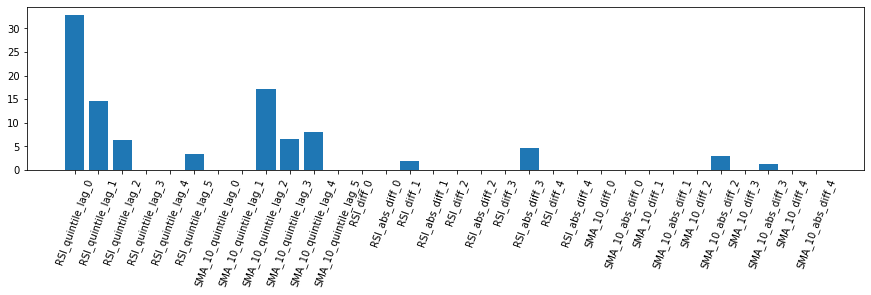

In [50]:
plt.figure(figsize=(15,3))
plt.bar(feature_names, model.feature_importances_)
plt.xticks(rotation=70)
plt.show()

## Evaluation on historic data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


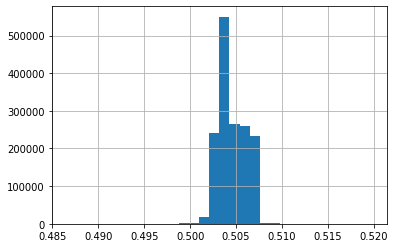

In [51]:
train_data[PREDICTION_NAME] = model.predict(train_data[feature_names])
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names])

#show prediction distribution, most should around the center
test_data[PREDICTION_NAME].hist(bins=30)

In [52]:
#From Jason Rosenfeld's notebook
#https://twitter.com/jrosenfeld13/status/1315749231387443202?s=20

def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [53]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)

Mean Correlation: 0.0186
Median Correlation: 0.0177
Standard Deviation: 0.0244


Mean Pseudo-Sharpe: 0.7614
Median Pseudo-Sharpe: 0.7268


Hit Rate (% positive eras): 78.14%


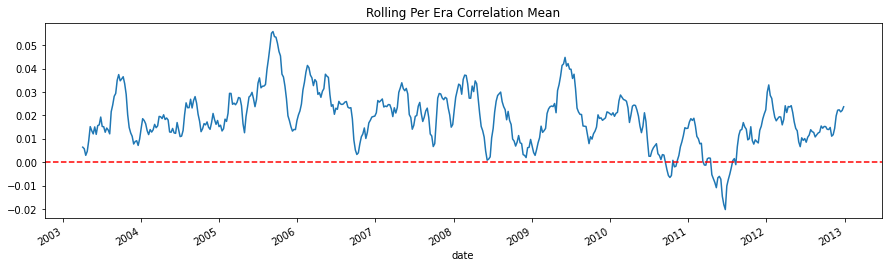

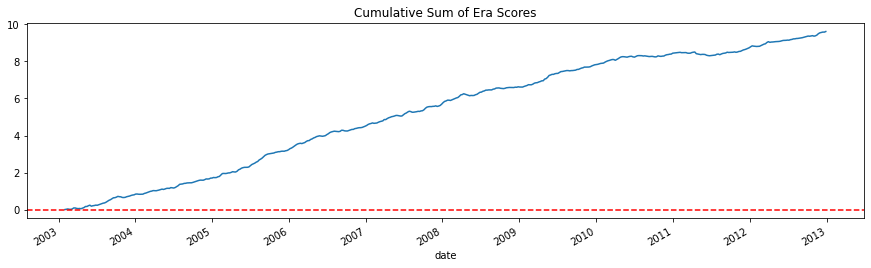

In [54]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0060
Median Correlation: 0.0060
Standard Deviation: 0.0203


Mean Pseudo-Sharpe: 0.2937
Median Pseudo-Sharpe: 0.2961


Hit Rate (% positive eras): 62.22%


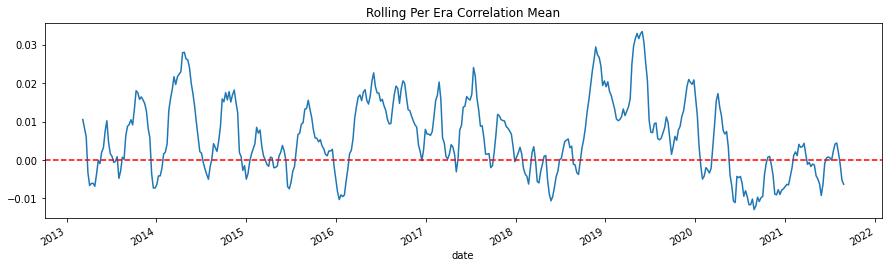

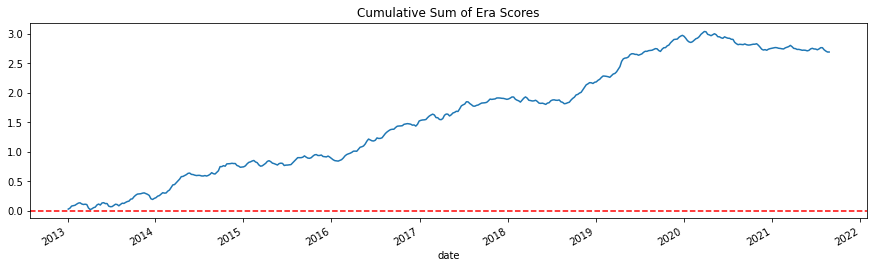

In [55]:
#test scores, out of sample
run_analytics(test_era_scores)

## Prediction on live data

In [56]:
# choose data as of most recent friday
last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime('%Y-%m-%d')

live_data = full_df.loc[date_string].copy()
live_data.dropna(subset=feature_names, inplace=True)

In [57]:
live_data

,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-08,000060 KS,000060 KS,000060.KS,29250.000000,29250.000000,29350.000000,28600.000000,28800.000000,295438.0,43.589744,4.471169e+06,1.0,4.0,1.0,0.0,1.0,1.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,000080 KS,000080 KS,000080.KS,34250.000000,34250.000000,35200.000000,34250.000000,34550.000000,333701.0,44.247788,7.120221e+06,2.0,4.0,2.0,3.0,2.0,2.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,000100 KS,000100 KS,000100.KS,59500.000000,59500.000000,60500.000000,59200.000000,59700.000000,227099.0,26.548673,1.368376e+07,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,000120 KS,000120 KS,000120.KS,147000.000000,147000.000000,151500.000000,147000.000000,151000.000000,44615.0,7.272727,5.730069e+07,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,000210 KS,000210 KS,000210.KS,69900.000000,69900.000000,71200.000000,69600.000000,70800.000000,92007.0,46.850394,3.860164e+07,2.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,ZUO,ZUO US,ZUO,16.650000,16.650000,16.809999,16.489000,16.719999,611000.0,48.858443,1.461363e+03,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,ZURN SW,ZURN SW,ZURN.SW,387.500000,387.500000,387.500000,384.600006,386.299988,181892.0,61.918614,8.090938e+04,3.0,3.0,3.0,2.0,1.0,1.0,1.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-08,ZWS,ZWS US,ZWS,36.459999,36.459999,37.130001,35.419998,36.939999,3294600.0,22.432781,9.833000e+02,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
print(f"Number of live tickers to submit: {len(live_data)}")
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names])

Number of live tickers to submit: 5200


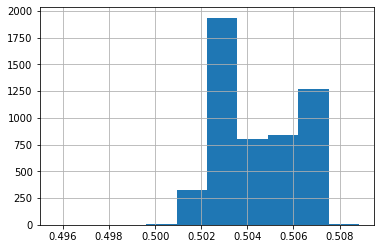

In [59]:
live_data[PREDICTION_NAME].hist()

You can simply run this without any modification

In [60]:
diagnostic_df = pd.concat([test_data, live_data])
diagnostic_df['friday_date'] = diagnostic_df.friday_date.fillna(
    last_friday.strftime('%Y%m%d')).astype(int)
diagnostic_df['data_type'] = diagnostic_df.data_type.fillna('live')
diagnostic_df[['ticker', 'friday_date', 'data_type',
                'signal']].reset_index(drop=True).to_csv(
    'example_signal_upload.csv', index=False)
print(
    'Example submission completed. Upload to signals.numer.ai for scores and live submission'
)

Example submission completed. Upload to signals.numer.ai for scores and live submission


In [61]:
diagnostic_df

,index,ticker,bloomberg_ticker,yahoo,close,raw_close,high,low,open,volume,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target_4d,target_20d,signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-04 00:00:00,2530.0,000060 KS,000060 KS,000060.KS,10106.674805,13000.000000,13250.000000,12950.000000,13000.000000,592131.0,37.179493,4.471169e+06,0.0,4.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,-2.0,2.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,1.00,0.50,0.506625
2013-01-11 00:00:00,2535.0,000060 KS,000060 KS,000060.KS,10573.136719,13600.000000,13600.000000,13200.000000,13450.000000,398890.0,51.612915,4.471169e+06,1.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130111,validation,0.25,0.25,0.506540
2013-01-18 00:00:00,2540.0,000060 KS,000060 KS,000060.KS,11000.725586,14150.000000,14550.000000,13800.000000,13850.000000,602322.0,50.000000,4.471169e+06,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130118,validation,1.00,0.25,0.506424
2013-01-25 00:00:00,2545.0,000060 KS,000060 KS,000060.KS,10961.854492,14100.000000,14200.000000,13600.000000,13650.000000,688156.0,59.756108,4.471169e+06,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130125,validation,0.00,0.00,0.505032
2013-02-01 00:00:00,2550.0,000060 KS,000060 KS,000060.KS,10456.520508,13450.000000,13550.000000,13250.000000,13300.000000,405298.0,40.476176,4.471169e+06,0.0,4.0,0.0,1.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130201,validation,0.75,0.25,0.506424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,NaN,ZUO,ZUO US,ZUO,16.650000,16.650000,16.809999,16.489000,16.719999,611000.0,48.858443,1.461363e+03,2.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20211008,live,NaN,NaN,0.502452
2021-10-08,NaN,ZURN SW,ZURN SW,ZURN.SW,387.500000,387.500000,387.500000,384.600006,386.299988,181892.0,61.918614,8.090938e+04,3.0,3.0,3.0,2.0,1.0,1.0,1.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20211008,live,NaN,NaN,0.504321
2021-10-08,NaN,ZWS,ZWS US,ZWS,36.459999,36.459999,37.130001,35.419998,36.939999,3294600.0,22.432781,9.833000e+02,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20211008,live,NaN,NaN,0.502860


In [62]:
ps = diagnostic_df.groupby('date')[PREDICTION_NAME].rank(pct=True, method="first")

In [63]:
diagnostic_df["signal"] = ps

In [64]:
diagnostic_df[["ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv("signal_upload.csv", index=False)

print("Upload to signals.numer.ai for scores and live submission")

Upload to signals.numer.ai for scores and live submission


## Uploading predictions using your API keys 🚀

Find your Numerapi public and private keys from https://numer.ai/account

To create a key for submission only, 

`Settings -> Create API key -> select "Upload Predictions" -> Save`


In [65]:
# NameOfYourAI
# Add keys between the quotes
public_id = "FHELSM6WLQN7O5ILH4DW2YSY45SCME7B"
secret_key = "5EEPKMBS3633NH27JJNYYYCXRDNOENFEZNRSNPYB3OQYSSO6DDKK5OFLMJDADWKQ"
model_id = "4b175161-c373-4c6c-bbd1-1b8f7f7caf89"
napi = numerapi.SignalsAPI(public_id=public_id, secret_key=secret_key)

In [66]:
submission_id = napi.upload_predictions(f"signal_upload.csv", model_id=model_id)

2021-10-10 09:34:38,042 INFO numerapi.base_api: uploading predictions...


And its done. Congratulations🎉. Your predictions for latest round are submitted! 


Check some information about your latest predictions on [Signals Tournament]
(https://signals.numer.ai/tournament). It will show some metrics like this,


![sign.png](https://cdn-images-1.medium.com/max/600/1*hTpX_ArF2DmPHRppVeM9Ig.png)




# About

Last updated: 2020-11-20

Created by: Suraj Parmar

- Numerai: [surajp](https://numer.ai/surajp)

- Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99)